# Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys    
#image_path = '/content/gdrive/MyDrive/'
#sys.path.append(image_path)
file_path = '/content/gdrive/MyDrive/df_image.csv'

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv(file_path)
df

,ID,TYPE,USER_ID,GENDER,AGE,NAME
0,60001,1,28449,NONE,21,060001_1_028449_NONE_21_new.jpg
1,60001,2,28449,NONE,21,060001_2_028449_NONE_21_new.jpg
2,60001,3,28449,NONE,21,060001_3_028449_NONE_21_new.jpg
3,60001,4,28449,NONE,21,060001_4_028449_NONE_21_new.jpg
4,60002,1,28450,FEMALE,30,060002_1_028450_FEMALE_30_new.jpg
...,...,...,...,...,...,...
8503,62126,4,29246,MALE,37,062126_4_029246_MALE_37_new.jpg
8504,62127,1,29247,MALE,23,062127_1_029247_MALE_23_new.jpg
8505,62127,2,29247,MALE,23,062127_2_029247_MALE_23_new.jpg
8506,62127,3,29247,MALE,23,062127_3_029247_MALE_23_new.jpg


In [ ]:
img_ds = np.load('/content/gdrive/MyDrive/data.npy')
img_ds.shape

(8508, 224, 224, 3)

In [ ]:
#np.random.shuffle(img_ds)
img_ds.shape

(8508, 224, 224, 3)

In [ ]:
x_train = img_ds[0:6000]
x_val = img_ds[6000:7500]
x_test = img_ds[7500:]
x_train.shape

(6000, 224, 224, 3)

In [ ]:
y_train = df['TYPE'][0:6000] - 1
y_val = df['TYPE'][6000:7500] - 1
y_test = df['TYPE'][7500:] - 1

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

(6000, 224, 224, 3) (6000, 4)
(1500, 224, 224, 3) (1500, 4)
(1008, 224, 224, 3) (1008, 4)


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalMaxPooling2D, Activation, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from matplotlib import pyplot as plt
from tensorflow.keras.applications.vgg19 import VGG19
import cv2
import seaborn as sns
import time
import numpy as np

In [ ]:
vgg19_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in vgg19_model.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg19_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(4, activation="softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 512)               262656    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 20,419,396
Trainable params: 395,012
Non-trainable params: 20,024,384
____________________________________

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 26, 26, 128)     

In [ ]:
#optimizer = keras.optimizers.adam(lr=1e-3)
optimizer = tf.keras.optimizers.Adamax(learning_rate = 1e-3)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc', 'AUC'])

In [ ]:
hist_softmax = model.fit(x_train, y_train, epochs=20, validation_data=(x_val,y_val), verbose=1, batch_size=32)
model.save('/content/gdrive/MyDrive/vgg_epoch' + str('20') +'.h5')

Epoch 1/20
188/188 [==============================] - 44s 229ms/step - loss: 0.7373 - acc: 0.7408 - auc: 0.9265 - val_loss: 0.4588 - val_acc: 0.8147 - val_auc: 0.9623
Epoch 2/20
188/188 [==============================] - 42s 223ms/step - loss: 0.3388 - acc: 0.8655 - auc: 0.9790 - val_loss: 0.4081 - val_acc: 0.8360 - val_auc: 0.9700
Epoch 3/20
188/188 [==============================] - 42s 226ms/step - loss: 0.2439 - acc: 0.9028 - auc: 0.9892 - val_loss: 0.3762 - val_acc: 0.8467 - val_auc: 0.9749
Epoch 4/20
188/188 [==============================] - 42s 224ms/step - loss: 0.1797 - acc: 0.9358 - auc: 0.9944 - val_loss: 0.4095 - val_acc: 0.8487 - val_auc: 0.9721
Epoch 5/20
188/188 [==============================] - 42s 225ms/step - loss: 0.1396 - acc: 0.9525 - auc: 0.9969 - val_loss: 0.3835 - val_acc: 0.8627 - val_auc: 0.9748
Epoch 6/20
188/188 [==============================] - 42s 225ms/step - loss: 0.1028 - acc: 0.9687 - auc: 0.9985 - val_loss: 0.4040 - val_acc: 0.8607 - val_auc: 0.974

In [ ]:
model = load_model('/content/gdrive/MyDrive/vgg_epoch20.h5')
model.evaluate(x_test, y_test)

In [ ]:
img_names = df['NAME'].values
img_types = df['TYPE'].values

In [ ]:
random_img_idx = np.random.randint(7500, 8508, 3)
print('random_img_idx: ', random_img_idx)

random_img_path = []
random_img_data = []
for i in random_img_idx:
  image_path = '/content/gdrive/MyDrive/Image/' + img_names[i]
  img = cv2.imread(image_path)
  random_img_path.append(image_path)
  random_img_data.append(img)
random_img_path

random_img_idx:  [8139 7822 8054]


['/content/gdrive/MyDrive/Image/062035_4_029214_MALE_26_new.jpg',
 '/content/gdrive/MyDrive/Image/061956_3_028275_FEMALE_29_new.jpg',
 '/content/gdrive/MyDrive/Image/062014_3_029206_FEMALE_23_new.jpg']

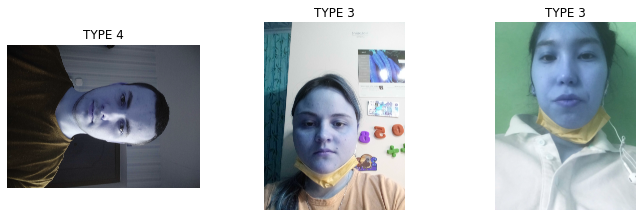

In [ ]:
re = ['TYPE 1 - The mask is worn correctly, covers the nose and mouth.',
    'TYPE 2 - The mask covers the mouth, but does not cover the nose.',
    'TYPE 3 - The mask is on, but does not cover the nose or mouth.',
    'TYPE 4 - There is no mask on the face.']

plt.figure(figsize=(20,20))
for i in range(len(random_img_data)) : 
  plt.subplot(5, 5, i+1)
  plt.imshow(random_img_data[i])   
  plt.axis('off')
  plt.title('TYPE ' + str(img_types[random_img_idx[i]]))

In [ ]:
def predictor(img_data):
  img_array = cv2.resize(img_data, (224, 224))
  img_array = np.expand_dims(img_array, axis=0)
  
  pred = model.predict(img_array)
  for p in range(len(pred[0])):
    if pred[0][p]==1.0 or abs(pred[0][p]-1)<=1e-3:
      print(re[p])

for i in range(len(random_img_data)):
  print('image ', i, end=':  ')
  predictor(random_img_data[i])

image  0:  image  1:  TYPE 3 - The mask is on, but does not cover the nose or mouth.
image  2:  TYPE 3 - The mask is on, but does not cover the nose or mouth.


In [ ]:
time_start = time.time()

eg_img_path = '/content/gdrive/MyDrive/Image/062126_1_029246_MALE_37_new.jpg'

def preditor(eg_img_path):
  img = cv2.imread(eg_img_path)
  img_array = cv2.resize(img, (224, 224))
  img_array = np.expand_dims(img_array, axis=0)
  
  pred = model.predict(img_array)
  for p in range(len(pred[0])):
    if pred[0][p]==1.0 or abs(pred[0][p]-1) <= 1e-3:
      print(re[p])

  # plt.figure(figsize=(6,6))
  # plt.imshow(img)
  # plt.axis('off')

preditor(eg_img_path)

time_end = time.time()
process_speed = time_end - time_start
print('Processing speed of a single image is: {:.2f} seconds' .format(process_speed)) 

TYPE 1 - The mask is worn correctly, covers the nose and mouth.
Processing speed of a single image is: 1.04 seconds


In [ ]:
def plot_history(r):
  plt.plot(r.history['accuracy'], label='train acc')
  plt.plot(r.history['val_accuracy'], label='val acc')
  plt.legend(loc='lower right')
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(np.arange(0, Epoch+1, step=5))
  plt.yticks(np.arange(0, 1.01, step=0.2))
  plt.show()

  plt.plot(r.history['loss'], label='train loss')
  plt.plot(r.history['val_loss'], label='val loss')
  plt.legend(loc='upper right')
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(np.arange(0, Epoch+1, step=5))
  plt.show()

plot_history(hist_softmax)

NameError: ignored

In [ ]:
y_test = df['TYPE'][7500:] - 1
y_test = y_test.values

predict_test = []
pred = model.predict(x_test)
for i in pred:
  for p in range(len(i)):
    if i[p]==1.0 or abs(i[p]-1) <= 0.5:
      predict_test.append(p)

In [ ]:
len(predict_test)

1003

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10,10))
cm = confusion_matrix(y_test, predict_test)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens)
plt.colorbar()

for i in range(len(cm)):
  for j in range(len(cm)):
    plt.annotate(cm[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center', size=14)

plt.title('Confusion Matrix\n')
plt.ylabel('True label', size=12)
plt.xlabel('Predicted label', size=12)
plt.xticks(range(0,4), labels=['1','2','3','4'])
plt.yticks(range(0,4), labels=['1','2','3','4'])
plt.show()


ValueError: ignored

<Figure size 720x720 with 0 Axes>

In [ ]:
FP = cm.sum(axis=0) - np.diag(cm)  
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

precision = np.mean(TP / (TP + FP))
recall = np.mean(TP / (TP + FN))

print('Precision: {:.6f}' .format(precision))
print('Recall: {:.6f}' .format(recall))

NameError: ignored